In [1]:
import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D, get_logger
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nib
import os
import time

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

logging = get_logger()

subjects = ['sub-UTS02', 'sub-001', 'sub-003', 'sub-004']
story = 'treasureisland'

tr = 1.5

from nilearn import plotting, datasets

# auditory envelope
audio, sr = load_mp3(STIMDIR, story)
sr = 48000
audio_envelope = get_envelope(audio)
story_length = len(audio) / sr # in seconds

# average envelope every 0.1 seconds
window = 0.1
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

zEnv = zscore(lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(13.5 // tr, story_length // tr) * tr), axis=0)

n_trs = zEnv.shape[0]

for hemi in ['L']:
    if hemi == 'L':
        cols = [0, 1]
        hemi_str = 'left'
    else:
        cols = [2, 3]
        hemi_str = 'right'

    surf_data_all = []
    for subject in subjects:
        surf_data = load_surf(DATADIR, subject, story, hemi)
        if subject[4:7] == 'UTS':
            tr_len = 2
        else:
            tr_len = 1.5
        surf_data = zscore(butterworth_highpass(surf_data, tr_len, 0.01), axis=1)
        if subject[4:7] == 'UTS':
            surf_data = surf_data[:, 5:] # trim the first 5 TRs to align with story start
            # resample to 1.5s TR
            surf_data = lanczosinterp2D(surf_data.T, np.arange(surf_data.shape[1]) * tr_len, np.arange(n_trs) * tr).T
        elif subject == 'sub-001':
            if story == 'odetostepfather': # trim the first 9 TRs of music
                surf_data = surf_data[:, 9:n_trs+9]
            else:
                surf_data = surf_data[:, 19:n_trs+19] # trim the first (10 + 9) TRs of wait period + music
        else:
            surf_data = surf_data[:, 17:n_trs+17] # trim the first (8 + 9) TRs of wait period + music
        surf_data_all.append(surf_data)

    surf_data_all = np.array(surf_data_all)
    
    n_voxels = surf_data_all.shape[1]

In [8]:
# build encoding model with audio envelope as regressor
from utils import make_delayed, pearsonr
from ridge import ridge_cv
n_reps = 10
encperf_all = np.zeros((n_reps, n_voxels))

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zEnv, np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

for irep in range(n_reps):
    logging.info(f'Processing {irep+1}th repetition; time: {time.ctime()}')
    wt, corr, best_alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(surf_data_all[3, :, :]).T, alphas, nfolds)
    encperf_all[irep, :] = voxcorrs

encperf = np.mean(encperf_all, axis=0)

encperf_median = np.median(encperf_all, axis=0)

[INFO] utils.<module> - Processing 1th repetition; time: Fri Nov 22 01:39:55 2024


[INFO] utils.<module> - Processing 2th repetition; time: Fri Nov 22 01:40:00 2024
[INFO] utils.<module> - Processing 3th repetition; time: Fri Nov 22 01:40:05 2024
[INFO] utils.<module> - Processing 4th repetition; time: Fri Nov 22 01:40:10 2024
[INFO] utils.<module> - Processing 5th repetition; time: Fri Nov 22 01:40:14 2024
[INFO] utils.<module> - Processing 6th repetition; time: Fri Nov 22 01:40:20 2024
[INFO] utils.<module> - Processing 7th repetition; time: Fri Nov 22 01:40:25 2024
[INFO] utils.<module> - Processing 8th repetition; time: Fri Nov 22 01:40:31 2024
[INFO] utils.<module> - Processing 9th repetition; time: Fri Nov 22 01:40:37 2024
[INFO] utils.<module> - Processing 10th repetition; time: Fri Nov 22 01:40:43 2024


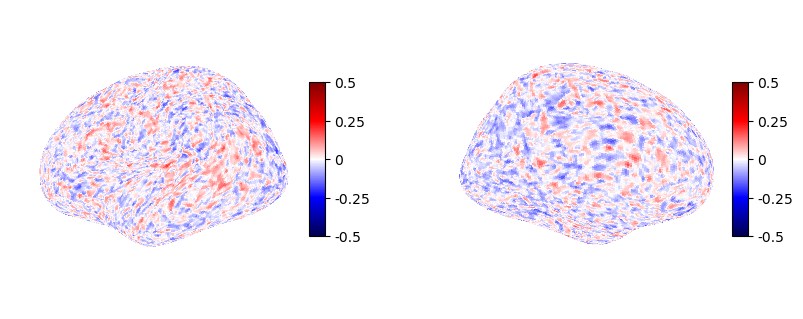

In [9]:
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage6")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fig_l = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[0])

fig_m = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[1])

fig.savefig(os.path.join(FIGDIR, f'sub-004_{story}_enc_envelope.png'))

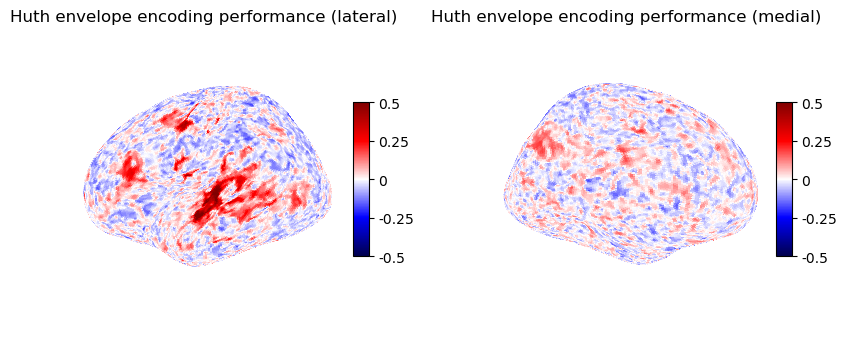

In [6]:
# use the huth subject's voxel to find best-matched voxels in my subjects
encperf_huth_all = np.zeros((n_reps, surf_data_all.shape[1]))
for i_rep in range(n_reps):
    wt, corr, best_alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(surf_data_all[0, :, :]).T, alphas, nfolds)
    encperf_huth_all[i_rep, :] = voxcorrs

encperf_huth = np.mean(encperf_huth_all, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fig_huth_l = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf_huth, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[0], title='Huth envelope encoding performance (lateral)')
fig_huth_m = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf_huth, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[1], title='Huth envelope encoding performance (medial)')

-0.0384509024017983


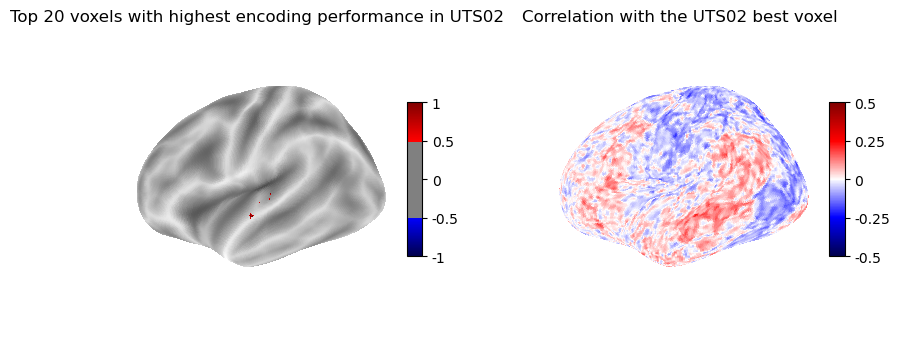

In [66]:
# find the huth voxel with the highest encoding performance
selvoxel = np.argsort(encperf_huth)[-1]
huth_surf_data = surf_data_all[0, selvoxel, :]

corr_huth = np.zeros((n_voxels,))
for i_voxel in range(n_voxels):
    corr_huth[i_voxel] = np.corrcoef(huth_surf_data, surf_data_all[3, i_voxel, :])[0, 1]

print(corr_huth[selvoxel])
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
f = plotting.plot_surf_stat_map(fsaverage.infl_left, corr_huth, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, title='Correlation with the UTS02 best voxel', axes=axes[1])

selvoxel_mask = np.zeros((n_voxels,))   
selvoxel_mask[np.argsort(encperf_huth)[-20:-1]] = 1

f1 = plotting.plot_surf_stat_map(fsaverage.infl_left, selvoxel_mask, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=1, vmin=-1, title='Top 20 voxels with highest encoding performance in UTS02', threshold=0.5, axes=axes[0])

fig.savefig(os.path.join(FIGDIR, 'sub-004_corr_UTS02.png'))

In [18]:
# for voxels with high correlation with huth voxel, plot their encoding performance
print(encperf[np.where(selvoxel_mask == 1)])
print(encperf[np.argsort(corr_huth)[-20:-1]])


[-0.04022409 -0.03478843 -0.0050864  -0.14547313 -0.03623869 -0.00998526
 -0.01431999  0.03997371 -0.00857938 -0.02405914 -0.05542973 -0.05256545
 -0.04173788 -0.04074085  0.00721299 -0.07307859 -0.08957563  0.0169875
 -0.06487498]
[0.11130227 0.066202   0.02644727 0.00919563 0.0781317  0.00983064
 0.02778747 0.03187807 0.03948045 0.02875205 0.07303606 0.13729606
 0.0924298  0.01961331 0.11273099 0.14687696 0.08502066 0.10510312
 0.14463462]


[0.25357613 0.24113589 0.23368213 0.22162417 0.21374109 0.20311115
 0.2022031  0.20192326 0.20180617 0.20155127]


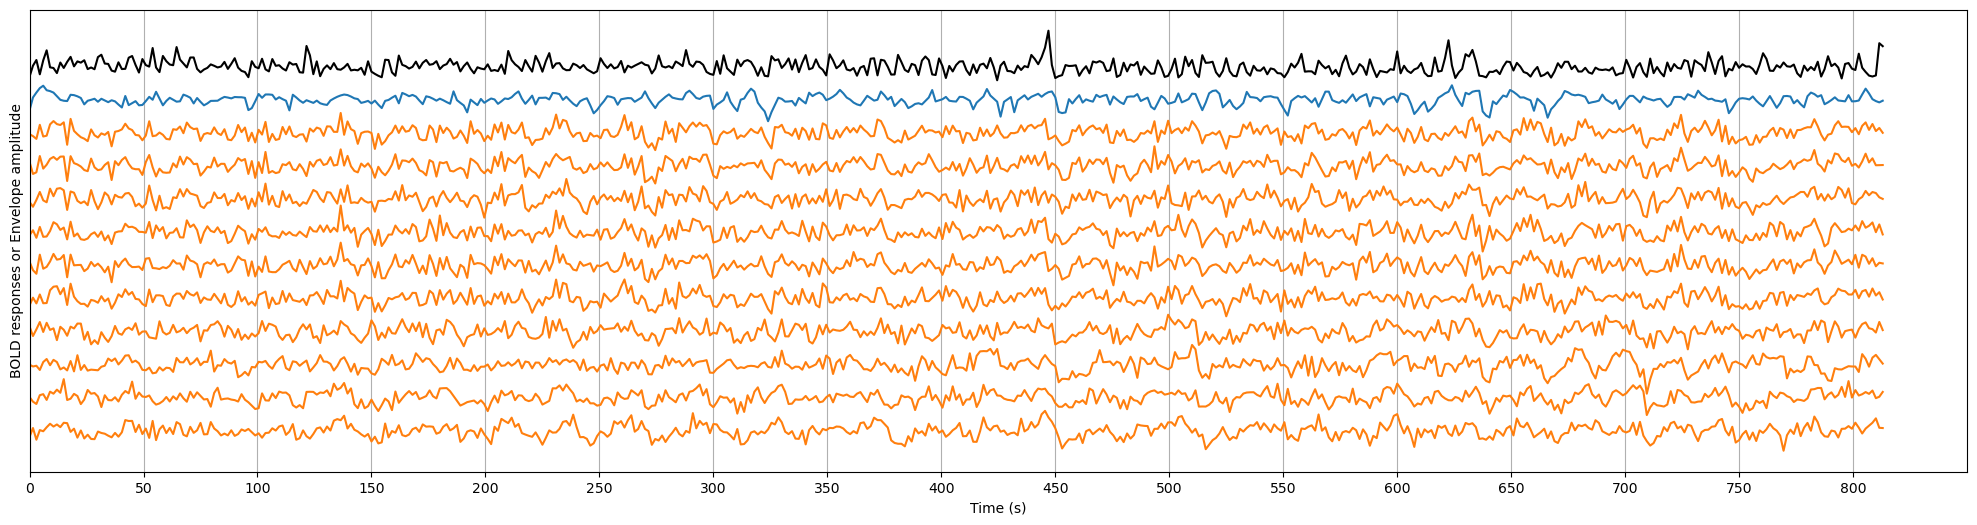

In [67]:
# plot the envelope, the selected huth voxel, and the vertices that have high correlation with the huth voxel
from matplotlib.pyplot import figure

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 10, "k-", label="Downsampled envelope (TR)")

ax.plot(np.arange(surf_data_all.shape[2]) * tr, surf_data_all[0][np.argmax(encperf_huth), :] + 5, color=colors[0], label="Selected Huth voxel")

highcorr_voxels = np.argsort(corr_huth)[::-1][:10]
print(corr_huth[highcorr_voxels])
for i, voxel in enumerate(highcorr_voxels):
    ax.plot(np.arange(surf_data_all.shape[2]) * tr, surf_data_all[3][voxel, :] - i * 5, color=colors[1])

ax.set_xlim(0, 850)
ax.set_xticks(range(0, 850, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()
f.savefig(os.path.join(FIGDIR, 'sub-004_corr_UTS02_timecourse.png'))

[ 2603 10284 10283 23117 23119 38772 12710 25997  9509 12822]
[0.25357613 0.24113589 0.23368213 0.22162417 0.21374109 0.20311115
 0.2022031  0.20192326 0.20180617 0.20155127]
[0.13873147 0.16424787 0.11467584 0.10653618 0.1734596  0.07482889
 0.09517023 0.04131273 0.11637643 0.08333249]
[[ 0.20626263  0.20937177  0.0984336   0.21963013  0.29136505  0.14780588
   0.10699219  0.08625376  0.07811053  0.22600009]
 [ 0.17266161  0.13393199  0.1562015   0.2059932   0.18470391  0.13574333
   0.20973083  0.08056092  0.15947542  0.08963912]
 [ 0.05821796  0.11790149  0.01398082  0.17380888  0.17747912  0.01282569
   0.05870649  0.02875036  0.11615623  0.11925712]
 [ 0.21779567  0.21919261  0.08582063  0.07655438  0.21484852  0.13369005
   0.12009678 -0.02870925  0.16749443  0.113629  ]
 [ 0.06809038  0.05110938  0.12306761  0.00063655  0.00752656  0.06070516
  -0.01086903  0.04827263  0.08611577  0.07841631]
 [ 0.08766378  0.09192285  0.15695372  0.0816282   0.11333465  0.02860547
   0.0838865 

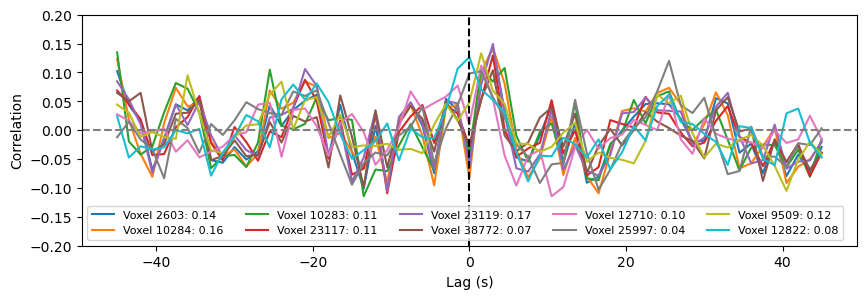

In [80]:
f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

for i, voxel in enumerate(highcorr_voxels):
    lags, ccorrs = lagcorr(surf_data_all[3][voxel, :], zEnv.flatten(), maxlag=30)
    # lags, ccorrs = lagcorr(surf_data_all[3][voxel, :], surf_data_all[0][np.argsort(encperf_huth)[-1], :], maxlag=100)
    ax.plot(lags * tr, ccorrs, label=f"Voxel {voxel}: {encperf[voxel]:.2f}")

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.2, 0.2)
ax.legend(ncol=5, prop={'size': 8})

print(highcorr_voxels)
print(corr_huth[highcorr_voxels])
print(encperf[highcorr_voxels])
print(encperf_all[:, highcorr_voxels])
f1.savefig(os.path.join(FIGDIR, 'sub-004_crosscorr_envelope.png'))

(-0.2, 0.2)

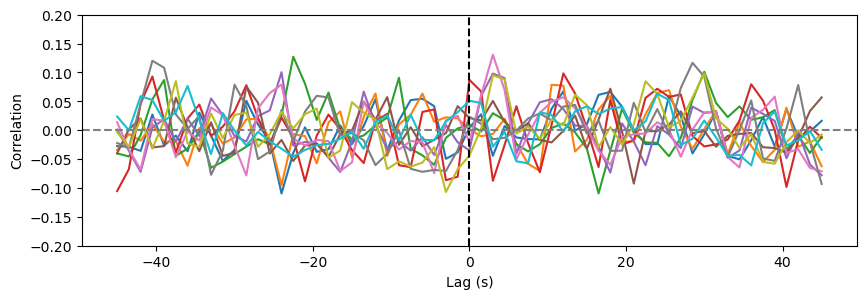

In [82]:
f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

highenc_voxels = np.argsort(encperf)[::-1][:10]
for i, voxel in enumerate(highenc_voxels):
    lags, ccorrs = lagcorr(surf_data_all[0][voxel, :], zEnv.flatten(), maxlag=30)
    ax.plot(lags * tr, ccorrs, label=f"Voxel {voxel}")

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.2, 0.2)

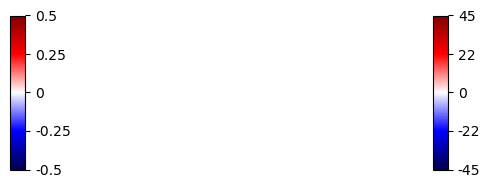

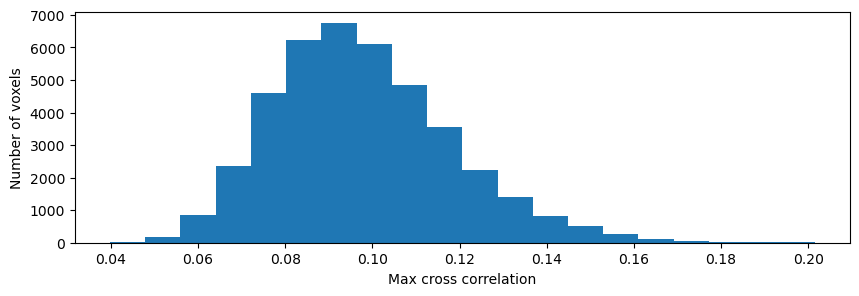

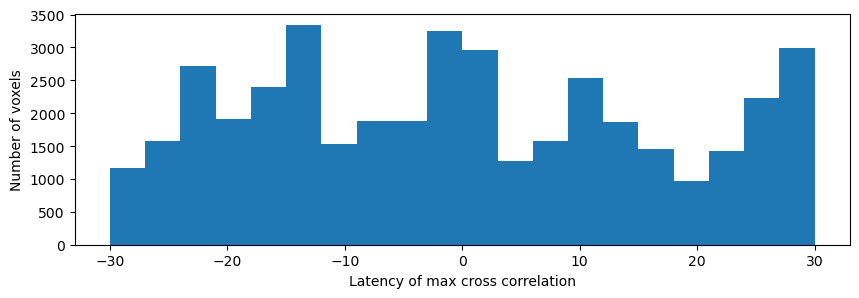

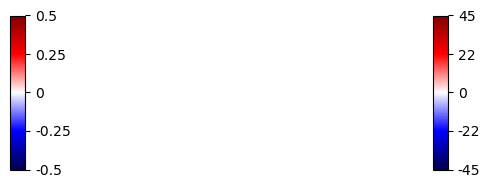

In [51]:
# calculate cross correlation between voxel responses and envelope
max_crosscorr = np.zeros((n_voxels,))
latency_maxcc = np.zeros((n_voxels,))

for i_voxel in range(n_voxels):
    lags, ccorrs = lagcorr(surf_data_all[3][i_voxel, :], zEnv.flatten(), maxlag=30)
    max_crosscorr[i_voxel] = np.max(ccorrs)
    latency_maxcc[i_voxel] = lags[np.argmax(ccorrs)]

f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
ax.hist(max_crosscorr, bins=20)
ax.set_xlabel("Max cross correlation")
ax.set_ylabel("Number of voxels")

f2 = figure(figsize=(10, 3))
f2.clf()
ax = f2.add_subplot(1,1,1)
ax.hist(latency_maxcc, bins=20)
ax.set_xlabel("Latency of max cross correlation")
ax.set_ylabel("Number of voxels")

f3, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
f3.clf()
plotting.plot_surf_stat_map(fsaverage.infl_left, max_crosscorr, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, title='Max cross correlation with envelope', axes=axes[0])
plotting.plot_surf_stat_map(fsaverage.infl_left, latency_maxcc, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=45, vmin=-45, title='Max cross correlation with envelope', axes=axes[1])


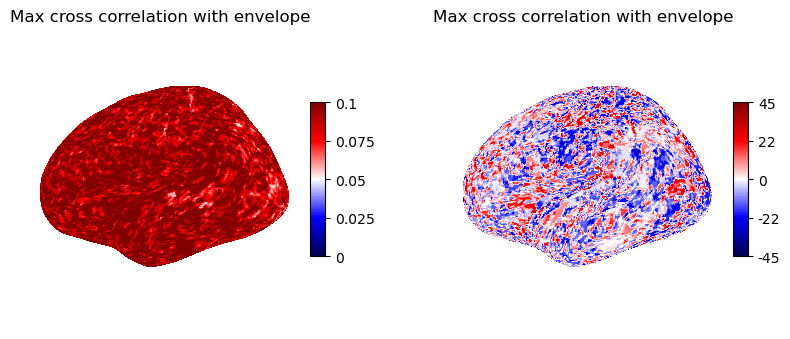

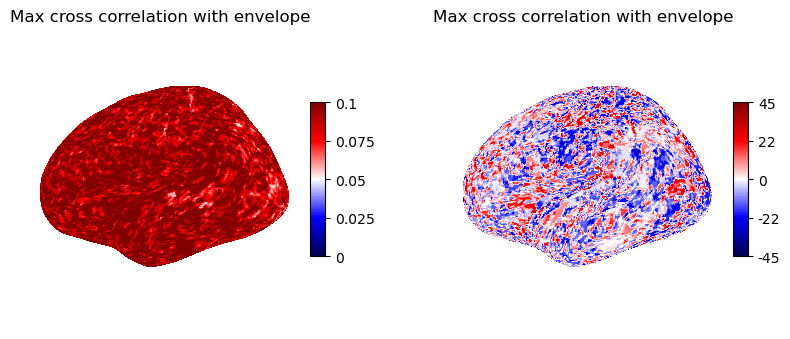

In [56]:
f3, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
plotting.plot_surf_stat_map(fsaverage.infl_left, max_crosscorr, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.1, vmin=0, title='Max cross correlation with envelope', axes=axes[0])
plotting.plot_surf_stat_map(fsaverage.infl_left, latency_maxcc, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=45, vmin=-45, title='Max cross correlation with envelope', axes=axes[1])
